In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from sklearn.datasets import load_digits
import torch

digits = load_digits()

kernels = {
    "hori": torch.tensor([[0, 0, 0],
                          [1, 1, 1], 
                          [0, 0, 0]]),
    "vert": torch.tensor([[0, 1, 0],
                          [0, 1, 0], 
                          [0, 1, 0]]),
    "diag1": torch.tensor([[1, 0, 0],
                           [0, 1, 0], 
                           [0, 0, 1]]),
    "diag2": torch.tensor([[0, 0, 1],
                           [0, 1, 0], 
                           [1, 0, 0]]),
    "blur": torch.tensor([[1, 1, 1],
                          [1, 1, 1], 
                          [1, 1, 1]]),
    "id": torch.tensor([[0, 0, 0],
                        [0, 1, 0], 
                        [0, 0, 0]])
}

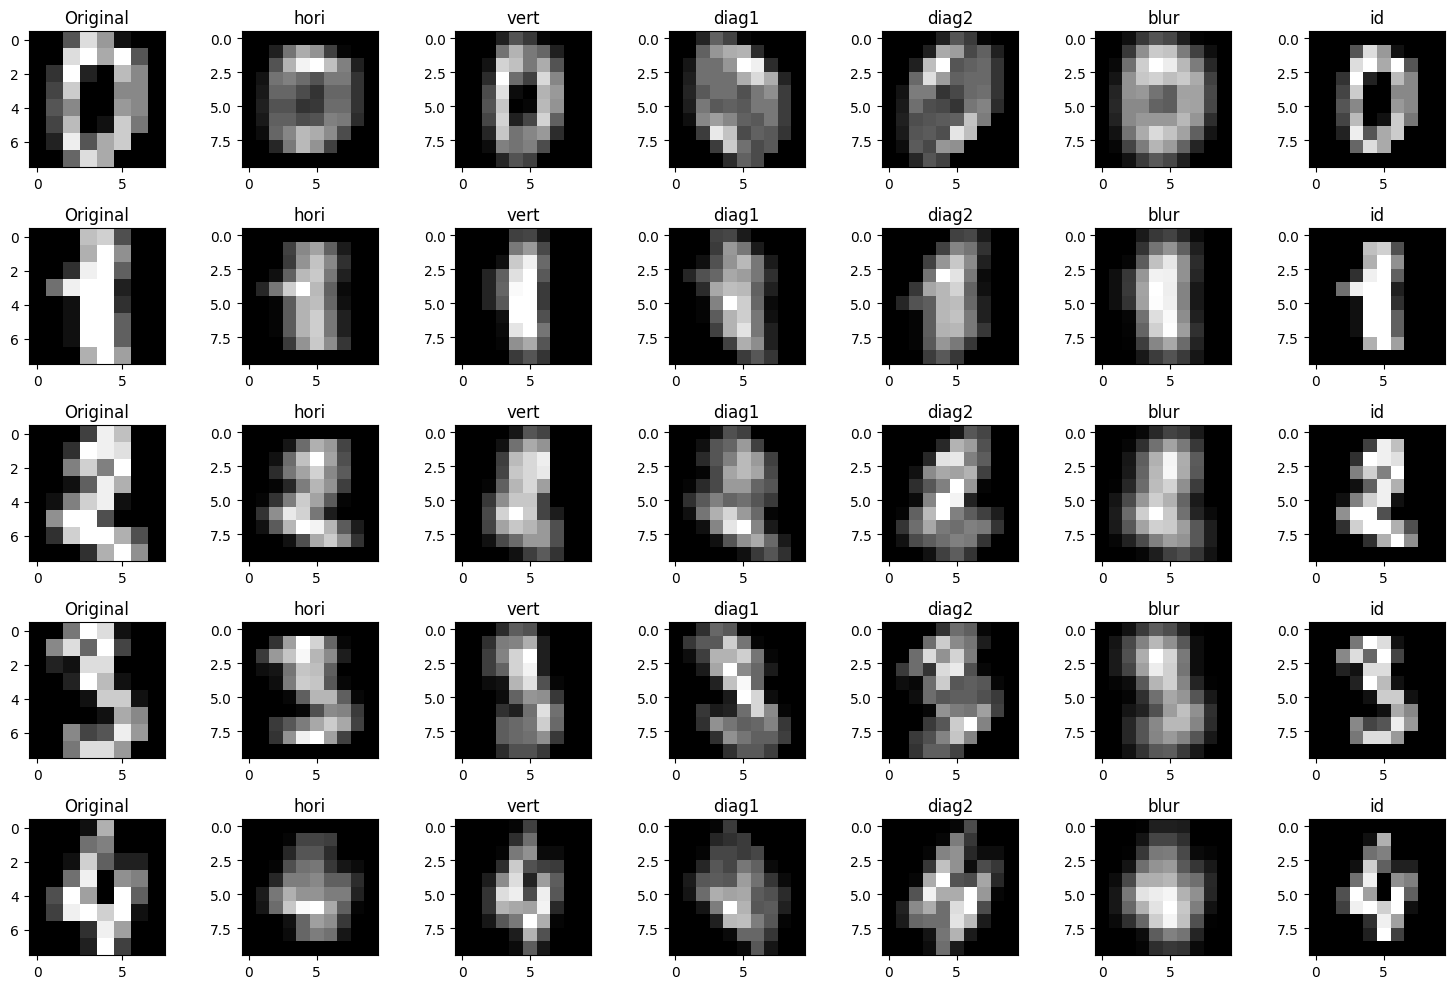

In [5]:
def corr2d(input_mat, kernel, padding=2, stride=1):
    '''
    Takens in input mat and kernel, and output the rseulting convolved matrix. 

    '''
    kernel_height, kernel_width = kernel.shape
    input_height, input_width = input_mat.shape

    output_height = (input_height + 2 * padding - kernel_height) // stride + 1
    output_width = (input_width + 2 * padding - kernel_width) // stride + 1

    padded = torch.nn.functional.pad(input_mat, (padding, padding, padding, padding), mode='constant', value=0)
    result = torch.zeros((output_height, output_width))

    # do the convolution
    for i in range(output_height):
        for j in range(output_width):
            select = padded[i: i + kernel_height, j: j + kernel_width]
            result[i][j] = torch.sum(select * kernel)
    
    return result


imgs = digits.images[:5]
kernel_names = list(kernels.keys())
fig, axes = plt.subplots(len(imgs), len(kernels) + 1, figsize=(15, 10))
for idx, img in enumerate(imgs):
    axes[idx, 0].imshow(img, cmap='gray')
    axes[idx, 0].set_title(f"Original")


    for i in range(len(kernels)):
        to_plot = corr2d(torch.from_numpy(digits.images[idx]), kernels[kernel_names[i]])
        axes[idx, i + 1].imshow(to_plot, cmap='gray')
        axes[idx, i + 1].set_title(f"{kernel_names[i]}")

plt.tight_layout()
plt.show()


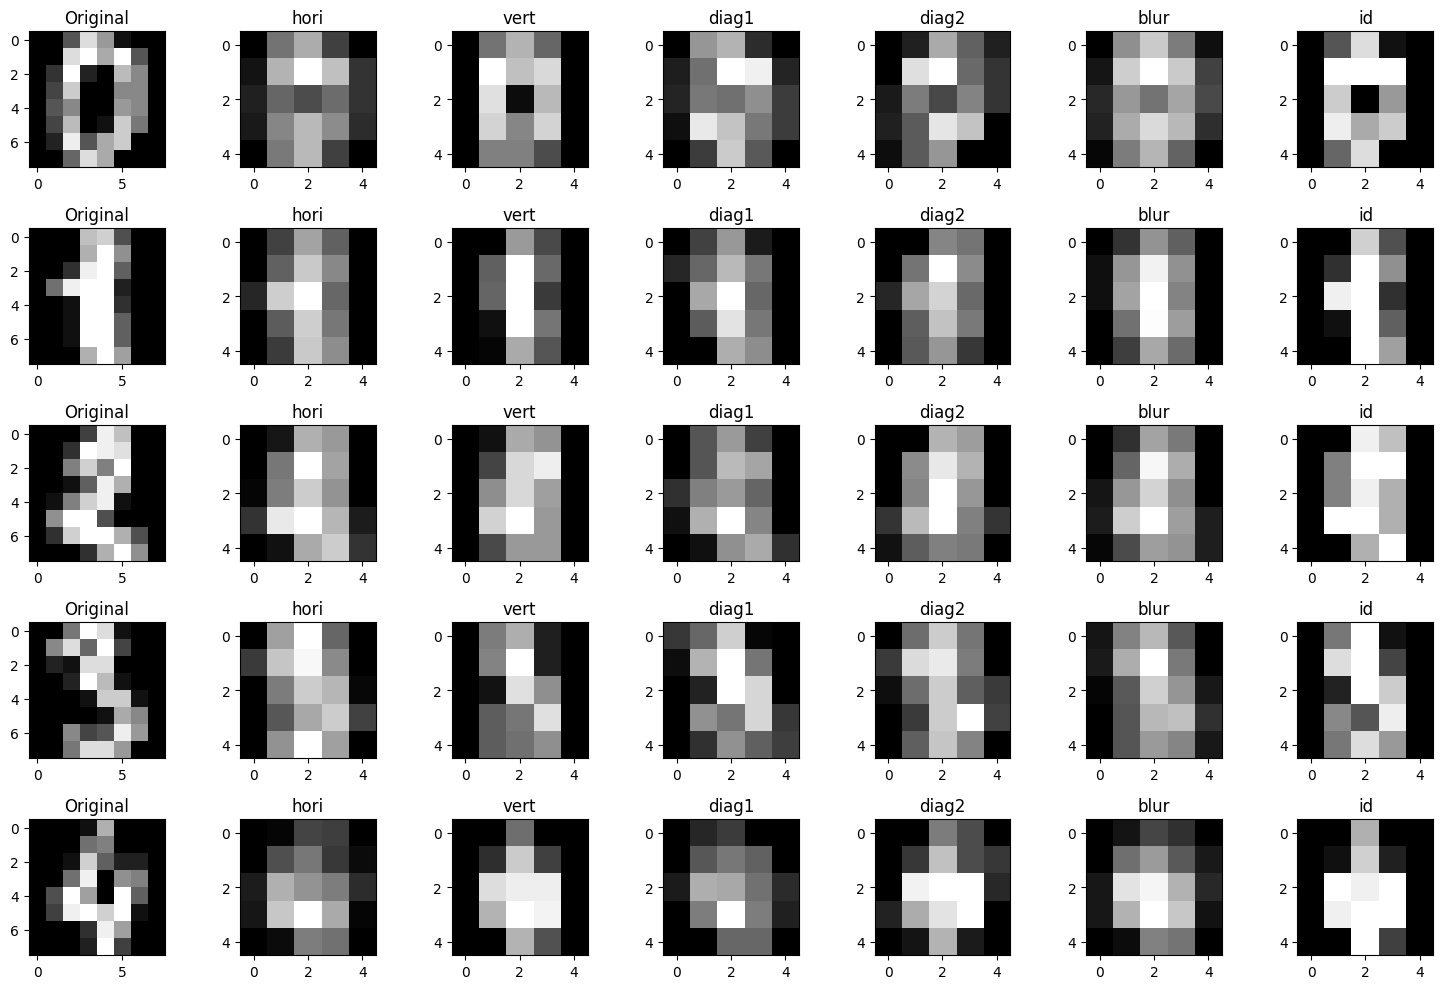

Before dimensions: torch.Size([10, 10]) 
After dimensions: torch.Size([5, 5])


In [6]:
# performs pooling on a given feature map
def pool2d(f_map, window_size, mode='max'):
    '''
    Performs pooling on a  given feature map. Supports max-pooling 
    and average pooling
    '''

    height, width = f_map.shape

    out_height = height // window_size
    out_width = width // window_size

    pooled = torch.zeros((out_height, out_width))

    for i in range(out_height):
        for j in range(out_width):
            select = f_map[i * window_size: (i + 1) * window_size ,  j * window_size: (j + 1) * window_size]
            if mode == 'max':
                pooled[i, j] = torch.max(select)
            elif mode == 'avg':
                pooled[i, j] = torch.mean(select)
    
    return pooled

# visualize
before_dim = None
after_dim = None
imgs = digits.images[:5]
kernel_names = list(kernels.keys())
fig, axes = plt.subplots(len(imgs), len(kernels) + 1, figsize=(15, 10))
for idx, img in enumerate(imgs):
    axes[idx, 0].imshow(img, cmap='gray')
    axes[idx, 0].set_title(f"Original")


    for i in range(len(kernels)):
        to_plot = corr2d(torch.from_numpy(digits.images[idx]), kernels[kernel_names[i]])
        before_dim = to_plot.shape
        to_plot = pool2d(to_plot, window_size=2, mode='max')
        after_dim = to_plot.shape
        axes[idx, i + 1].imshow(to_plot, cmap='gray')
        axes[idx, i + 1].set_title(f"{kernel_names[i]}")

plt.tight_layout()
plt.show()

print(f"Before dimensions: {before_dim} \nAfter dimensions: {after_dim}")

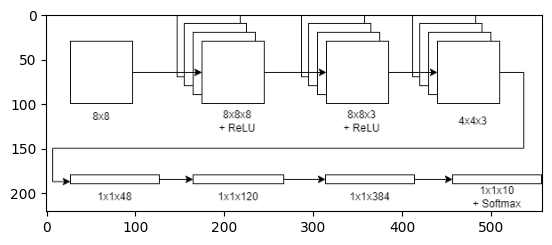

In [9]:
import matplotlib.image as mpimg
img = mpimg.imread('cs480a4_cnn.drawio (1).png')
imgplot = plt.imshow(img)
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # conv layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # fully connected. 
        self.fc1 = nn.Linear(in_features=4 * 4  * 3, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1) # to account for batches. 
        x = self.fc3(self.fc2(self.fc1(x)))
        return x

In [11]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm

# constants
BATCH_SIZE = 16
LR = 0.001
MOMENTUM = 0.9
EPOCHS = 1000

In [12]:
digits = load_digits()

imgs = digits.images
classes = digits.target

img = digits.images[0]
imgs = np.asarray([np.divide(img, np.max(img)) for img in imgs])

imgs = imgs[:, np.newaxis, :, :]

# stratify split into 0.4 train, 0.4 
X_temp, X_test, y_temp, y_test = train_test_split(imgs, classes, test_size=0.2, stratify=classes)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

# convert to tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)

# dataloaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE)

min_val_loss = None
train_losses, val_losses = [], []
checkpoint = 'best.pth'

# model params 
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

for epoch in tqdm(range(EPOCHS), desc="Training progress"):
    model.train()
    train_loss = 0.0
    for X, y in train_loader: 
        preds = model(X)
        loss = criterion(preds, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    for X, y in val_loader:
        preds = model(X)
        loss = criterion(preds, y)
        val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # checkpointing
    if min_val_loss == None or val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint)

Training progress: 100%|██████████| 1000/1000 [04:35<00:00,  3.63it/s]


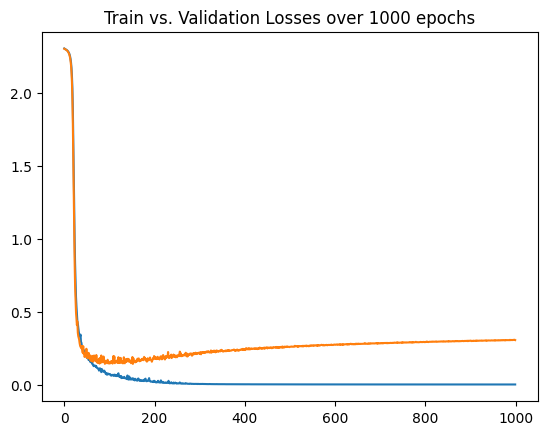

In [13]:
# plot training and validation loss over time

plt.plot(range(0, len(train_losses)), train_losses, label='Train Losses')
plt.plot(range(0, len(train_losses)), val_losses, label='Validation Losses')
plt.title("Train vs. Validation Losses over 1000 epochs")
plt.show()

In [14]:
# final accuracy from test dataset
model.eval()
preds = model(X_test)
loss = criterion(preds, y_test)

probs = F.softmax(preds, dim=1)
pred_labels = torch.argmax(probs, dim=1)

correct = (y_test == pred_labels).sum().item()
print(f"Accuracy: {correct / len(y_test)}")

Accuracy: 0.9611111111111111


In [15]:
from sklearn.svm import SVC

svc = SVC(kernel='sigmoid', C=1, gamma=0.001)

imgs_1d = [i.ravel() for i in imgs]

# imgs1d = 
X_train1d = np.asarray([i.ravel() for i in X_train.numpy()])
X_val1d = np.asarray([i.ravel() for i in X_val.numpy()])
X_test1d = np.asarray([i.ravel() for i in X_test.numpy()])

svc.fit(X_train1d, y_train)
preds = svc.predict(X_test1d)
correct = (preds == y_test).sum()
print(f"SVC Acc: {correct / len(y_test)}")

SVC Acc: 0.20000000298023224
